In [1]:
from diffusers import DiffusionPipeline
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os

/root/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('/root/flux')

In [3]:
from lora_train import gpt_api
from symbols_priority import system_prompt


In [4]:
gpt = gpt_api.GptApi(model_name='gpt-4.5-preview')
out = await gpt.ask_gpt(user_input='Bitcoin Cryptocurrency', system_prompt=system_prompt.SYSTEM_PROMPT)

In [7]:
icon_prompts = list(out['icon_prompts'].values())

In [6]:
out

{'slot_icons': ['Bitcoin King',
  'Golden Crypto Wallet',
  'Ethereum Crystal',
  'Blockchain Node',
  'Digital Coin'],
 'icon_prompts': {'Bitcoin King': 'Luxurious golden-framed portrait of the Bitcoin King, confidently standing in a regal attire adorned with golden Bitcoin symbols, surrounded by glittering golden digital streams.',
  'Golden Crypto Wallet': 'Vibrant, ornate golden crypto wallet visually overflowing with shiny Bitcoin coins, presented warmly on a background of fiery orange digital lights.',
  'Ethereum Crystal': 'Ethereal purple Ethereum crystal floating elegantly, emitting mesmerizing sparks of magical violet energy against a mysterious futuristic background.',
  'Blockchain Node': 'Stylized green blockchain node interconnected with glowing emerald links, giving off a friendly yet intricate digital vibe.',
  'Digital Coin': 'Minimalistic yet polished blue digital coin subtly glowing, elegant and sleek against a calming technological blue gradient background.'}}

In [16]:
model_id = 'black-forest-labs/FLUX.1-dev'
pipe = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.bfloat16)
pipe.enable_model_cpu_offload()

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


In [18]:
def plot_images(images: dict[str, 'Image.Image']):
    fig, axes = plt.subplots(1, len(images), figsize=(len(images) * 4, 6), facecolor='white')  # white background
    for i, (name, img) in enumerate(images.items()):
        axes[i].imshow(img)
        axes[i].set_title(name[:10], color='black')  # only first 10 letters
        axes[i].axis('off')  # hide axis
        axes[i].set_facecolor('white')  # white panel background
    plt.tight_layout()
    plt.show()

In [12]:
loras_paths_dict = {
    # 'base': {'lora_path': None, 'trigger_word': None},
    'pic_a': {'lora_path': '/root/lora_pic_a.safetensors', 'trigger_word': 'bbartstylecomp, pica style, luxurious style, gold, high importance, warm tones'},
    'pic_b': {'lora_path': '/root/lora_pic_b.safetensors', 'trigger_word': 'bbartstylecomp, picb style, large size of object, warm tones, high importance of icon, slot icon, icon, Large'},
    'pic_c': {'lora_path': '/root/lora_pic_c.safetensors', 'trigger_word': 'bbartstylecomp, picс style, medium size of object, violet tones, medium importance of icon, slot icon, icon, medium'},
    'pic_d': {'lora_path': '/root/lora_pic_e.safetensors', 'trigger_word': 'bbartstylecomp, pice style, green tones, low importance of icon, slot icon, icon, small'},
    'pic_e': {'lora_path': '/root/lora_pic_e.safetensors', 'trigger_word': 'bbartstylecomp, pice style, blue tones, low importance of icon, slot icon, icon, small'},
}

style_lora_path = '/root/lora_style.safetensors'

In [13]:
def inference_with_lora(prompt: str, trigger_word: str, lora_path: str | None = None):
    pipe.unload_lora_weights()
    if lora_path:
        pipe.load_lora_weights(lora_path, adapter_name="high")
        pipe.load_lora_weights(style_lora_path, adapter_name="style")
        pipe.set_adapters(["high", 'style'], adapter_weights=[1.0, 1.0])
    prompt = f'{trigger_word}, {prompt}'
    generator = torch.Generator(device='cpu').manual_seed(21)
    image = pipe(prompt=prompt, height=1024, width=1024, num_inference_steps=20, guidance_scale=3.0, generator=generator).images[0]
    if lora_path:
        pipe.unload_lora_weights()
    return image



In [14]:
def multi_inference(prompt: str, lora_paths: dict[str, str]):
    images = {}
    for name, lora_config in lora_paths.items():
        images[name] = inference_with_lora(prompt, lora_path=lora_config['lora_path'], trigger_word=lora_config['trigger_word'])
    return images

In [11]:
# prompt = 'big size, ultra close up portrait, pica style, luxurious style, gold, high importance, warm tones, slot icon style, ultra close up, Puss in Boots wearing oversized golden hat with ruby feather, ornate scarlet cloak with embroidered lions, holding a glowing rapier encrusted with emeralds, background: tavern fireplace and flickering candlelight — dashing, dangerous, deluxe'

# imgs = multi_inference(prompt, loras_paths_dict)

In [12]:
slot_icons = [
    "Harry Potter",
    "Albus Dumbledore",
    "Hermione Granger",
    "Ron Weasley",
    "Lord Voldemort"
]

In [48]:
list(loras_paths_dict.items())[0][1]

{'lora_path': '/root/lora_pic_a.safetensors',
 'trigger_word': 'bbartstylecomp, pica style, luxurious style, gold, high importance, warm tones'}

In [10]:
def inference_characters(prompts: list[str], lora_paths: dict[str, dict[str, str]]):
    results = {}
    for i, prompt in enumerate(prompts):
        lora_key = list(lora_paths.keys())[i]  # Get the corresponding LoRA key
        lora_config = lora_paths[lora_key]
        results[f"{lora_key}_{prompt}"] = inference_with_lora(
            prompt=prompt,
            trigger_word=lora_config['trigger_word'],
            lora_path=lora_config['lora_path']
        )
    return results


In [50]:
slot_icons = [
    "Harry Potter",
    "Golden Snitch",
    "Sorting Hat",
    "Potion Bottle",
    "Magic Wand"
]

icon_prompts = [
    "Harry Potter portrait with round glasses, lightning-shaped scar, and Gryffindor scarf, surrounded by glowing magic sparks.",
    "Golden Snitch with fluttering silver wings, shining brightly against a Quidditch stadium backdrop.",
    "Old Sorting Hat resting on a wooden stool, illuminated softly with magical glow in Hogwarts hall.",
    "Colorful Potion Bottle shimmering softly on an old wooden shelf filled with mysterious magical ingredients.",
    "Elegant Magic Wand emitting gentle magical sparkles, lying on a velvet cushion in a cozy wizarding shop."
]


In [54]:
res = inference_characters(icon_prompts, loras_paths_dict)


No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
/root/venv/lib/python3.11/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
100%|██████████| 20/20 [00:21<00:00,  1.09s/it

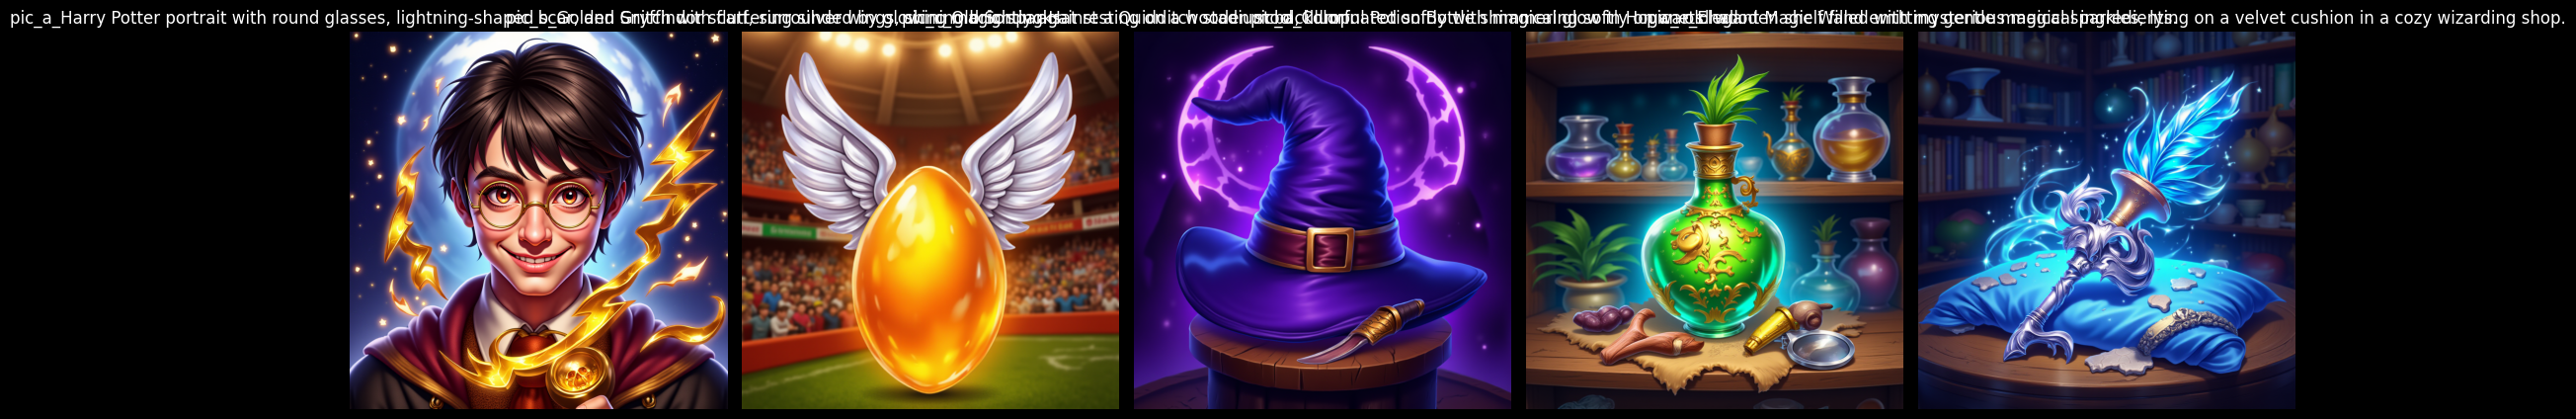

In [55]:
plot_images(res)

In [56]:
slot_icons = [
    "Shrek",
    "Donkey",
    "Puss in Boots",
    "Gingerbread Man",
    "Magic Mirror"
]

icon_prompts = [
    "Cheerful Shrek smiling broadly, surrounded by swamp plants and fireflies.",
    "Playful Donkey with a mischievous grin, standing in a sunny meadow.",
    "Charming Puss in Boots with feathered hat, posing heroically against a fairytale backdrop.",
    "Cute Gingerbread Man running cheerfully, leaving sugary sprinkles behind him.",
    "Enchanted Magic Mirror shimmering gently, framed elegantly on a castle wall."
]

In [57]:
res_shrek = inference_characters(icon_prompts, loras_paths_dict)

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
/root/venv/lib/python3.11/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
100%|██████████| 20/20 [00:22<00:00,  1.10s/it

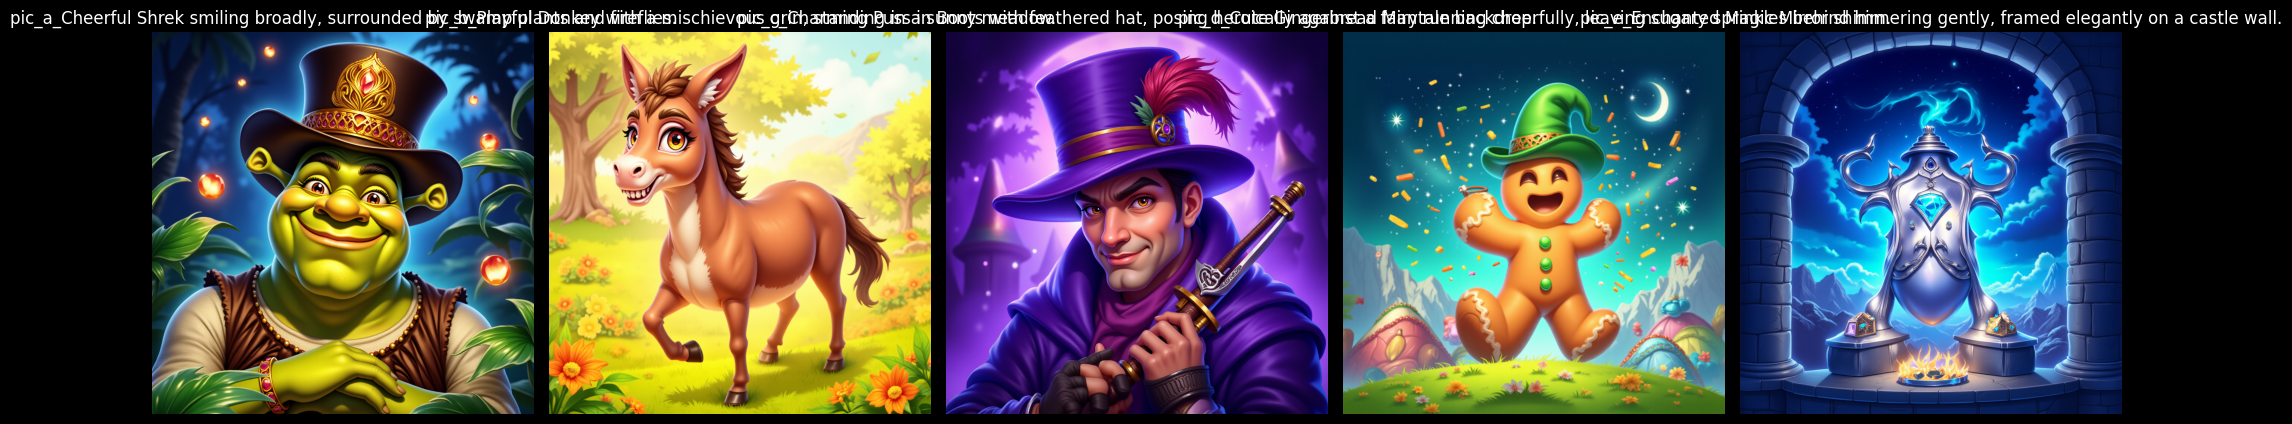

In [58]:
plot_images(res_shrek)

In [59]:
slot_icons = [
    "Shrek",
    "Donkey",
    "Magic Potion",
    "Swamp Frog",
    "Blue Fairy Dust"
]

icon_prompts = {
    "Shrek": "Luxurious golden-framed portrait of Shrek, confidently smiling, wearing a golden crown, surrounded by golden sparkles and rich emerald accents.",

    "Donkey": "Friendly Donkey smiling warmly, standing in front of a sunset-lit meadow filled with vibrant orange and yellow flowers.",

    "Magic Potion": "Glowing purple magic potion bottle emitting gentle sparkles, resting elegantly on a mystical wooden table.",

    "Swamp Frog": "Cute, vibrant green swamp frog sitting happily on a lily pad surrounded by lush marsh vegetation.",

    "Blue Fairy Dust": "Sparkling blue fairy dust sprinkled delicately over a small pouch, shimmering softly against a twilight background."
}

In [13]:
res = inference_characters(icon_prompts, loras_paths_dict)


No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
/root/venv/lib/python3.11/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
100%|██████████| 20/20 [00:28<00:00,  1.41s/it

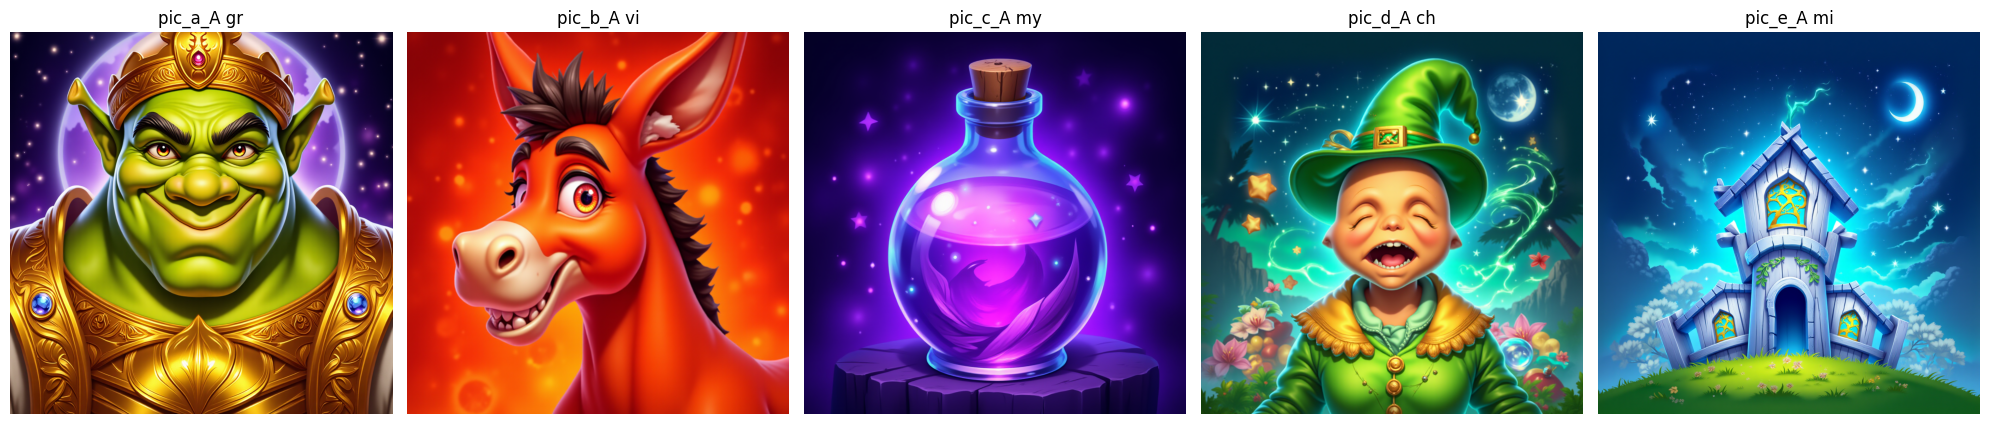

In [14]:
plot_images(res)

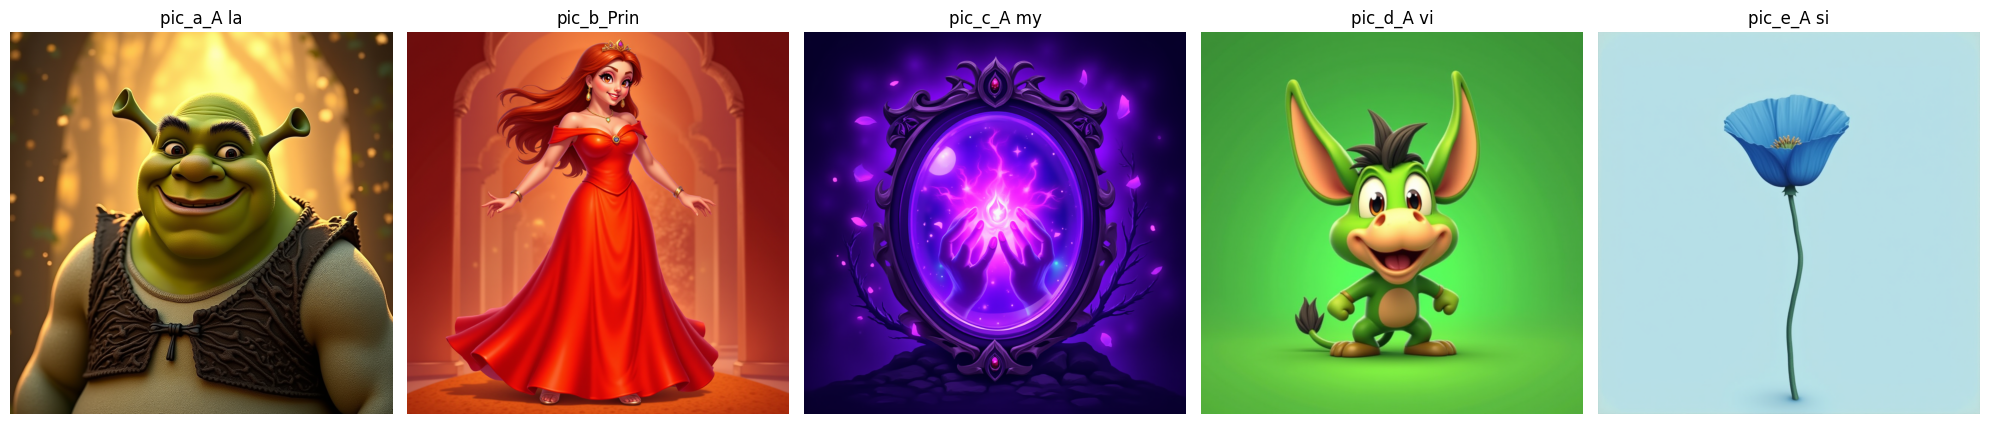

In [ ]:
plot_images(res)

In [8]:
out

{'slot_icons': ['Bitcoin King',
  'Golden Crypto Wallet',
  'Ethereum Crystal',
  'Blockchain Node',
  'Digital Coin'],
 'icon_prompts': {'Bitcoin King': 'Luxurious golden-framed portrait of the Bitcoin King, confidently standing in a regal attire adorned with golden Bitcoin symbols, surrounded by glittering golden digital streams.',
  'Golden Crypto Wallet': 'Vibrant, ornate golden crypto wallet visually overflowing with shiny Bitcoin coins, presented warmly on a background of fiery orange digital lights.',
  'Ethereum Crystal': 'Ethereal purple Ethereum crystal floating elegantly, emitting mesmerizing sparks of magical violet energy against a mysterious futuristic background.',
  'Blockchain Node': 'Stylized green blockchain node interconnected with glowing emerald links, giving off a friendly yet intricate digital vibe.',
  'Digital Coin': 'Minimalistic yet polished blue digital coin subtly glowing, elegant and sleek against a calming technological blue gradient background.'}}

In [ ]:
res = inference_characters(icon_prompts, loras_paths_dict)
plot_images(res)

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
/root/venv/lib/python3.11/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
100%|██████████| 20/20 [00:27<00:00,  1.36s/it

NameError: name 'plot_images' is not defined

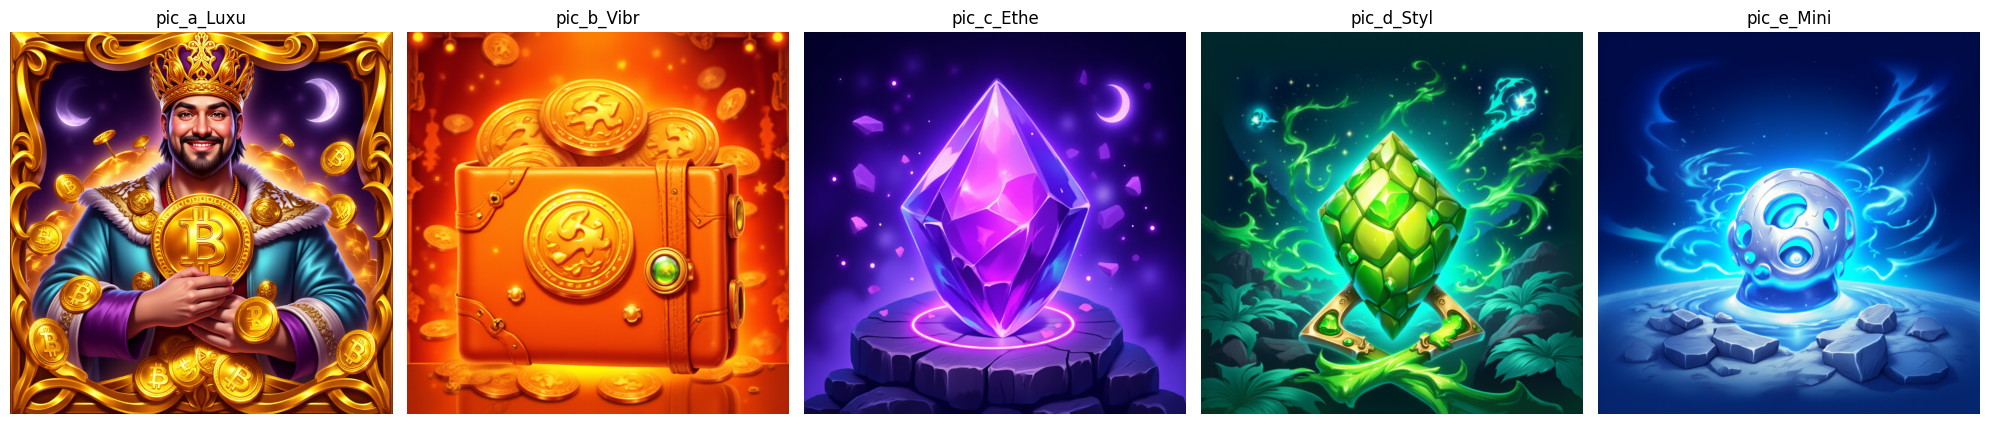

In [19]:
plot_images(res)